Preparing the Dataset
=====================

Now that we have successfully imported the C04B21 dual-energy CT dataset 
in the previous part of the tutorial, we can proceed with preparing the 
dataset for the Monte Carlo inversion. In this part, we will perform the 
necessary pre-processing steps to get the data ready.

In this tutorial, we will process this data directly within the Jupyter Notebook, 
in a parallel MPI (Message Passing Interface) environment using 
[ipyparallel](https://ipyparallel.readthedocs.io/).

The machine used in this tutorial has 8 GPUs available, which will significantly 
enhance processing speed due to the parallel computation capabilities of RockVerse. 
Let's create a cluster with a set of 8 MPI engines. RockVerse will automatically 
assign one MPI process to each GPU.


Start a parallel MPI cluster
----------------------------

In [1]:
import ipyparallel as ipp

# Create an MPI cluster with 8 engines
cluster = ipp.Cluster(engines="mpi", n=8)

# Start and connect to the cluster
rc = cluster.start_and_connect_sync()

# Enable IPython magics for parallel processing
rc[:].activate()


Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/8 [00:00<?, ?engine/s]

This will enable the `%%px` 
[cell magic](https://ipyparallel.readthedocs.io/en/latest/examples/Parallel%20Magics.html#px-cell-magic), 
which allows RockVerse to perform parallel processing interactively within this Jupyter notebook.

Next, let's create the dual energy group and copy the images we 
imported [in the previous part of this tutorial](./dual_energy_tutorial_download_data.ipynb). 

The `copy_image` method below will create a new image in the Zarr store, giving us the 
opportunity to change the chunk size. Monte Carlo dual energy processing utilizes all 
MPI processes to share the load of each individual chunk. Once processing for each chunk 
is finished, RockVerse will write a checkpoint to the file system, allowing the 
simulation to be resumed in case it crashes midway.

Therefore, prefer smaller chunks if you want frequent checkpoints, but not so small that the 
read/write overhead becomes considerable. Considering our image shape and the 8 available GPUs,
we'll copy the original CT scans creating 16 chunks.

In [2]:
%%px --block

import matplotlib.pyplot as plt
from IPython.display import display
import rockverse as rv

# Create the Dual Energy CT group
dectgroup = rv.dualenergyct.create_group(
    store='/path/to/dual_energy_ct/C04B21',
    overwrite=True)

# Copy the low energy CT image
dectgroup.copy_image(
    image=rv.open(store='/path/to/imported/dual_energy_carbonate/C04B21Raw100keV'),
    name='lowECT',
    chunks=16,
    overwrite=True)

# Copy the high energy CT image
dectgroup.copy_image(
    image=rv.open(store='/path/to/imported/dual_energy_carbonate/C04B21Raw140keV'),
    name='highECT',
    chunks=16,
    overwrite=True)


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[stdout:0] [2025-02-25 13:52:50] Copying: 100% 16/16 [00:03<00:00,  4.91chunk/s]
[2025-02-25 13:52:54] Copying: 100% 16/16 [00:03<00:00,  5.03chunk/s]


Now, let's take a quick look at the data using the orthogonal viewer:

[stdout:0] [2025-02-25 13:54:41] Histogram Low energy attenuation (min/max): 100% 16/16 [00:00<00:00, 32.28chunk/s]
[2025-02-25 13:54:42] Histogram Low energy attenuation (counting voxels): 100% 16/16 [00:03<00:00,  4.11chunk/s]
[2025-02-25 13:54:49] Histogram High energy attenuation (min/max): 100% 16/16 [00:00<00:00, 42.76chunk/s]
[2025-02-25 13:54:50] Histogram High energy attenuation (counting voxels): 100% 16/16 [00:01<00:00,  9.08chunk/s]


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[output:0]

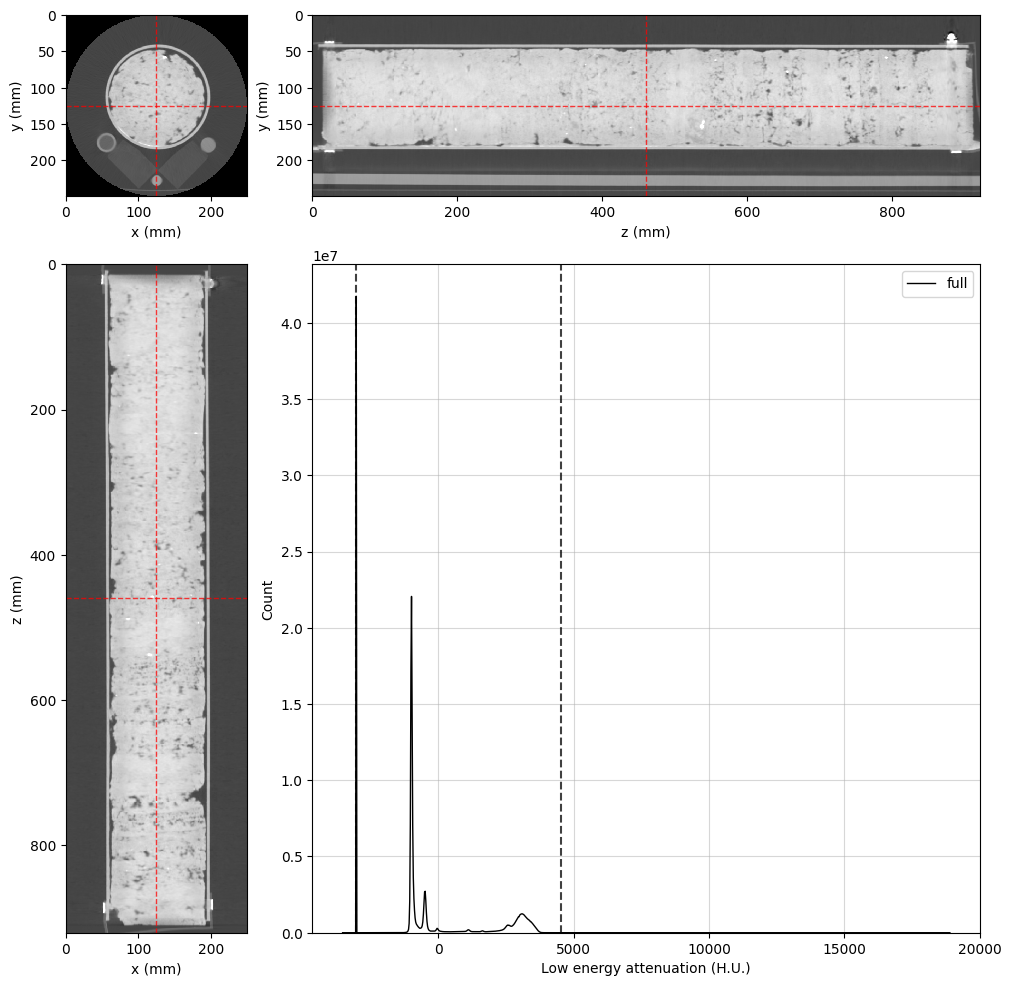

[output:0]

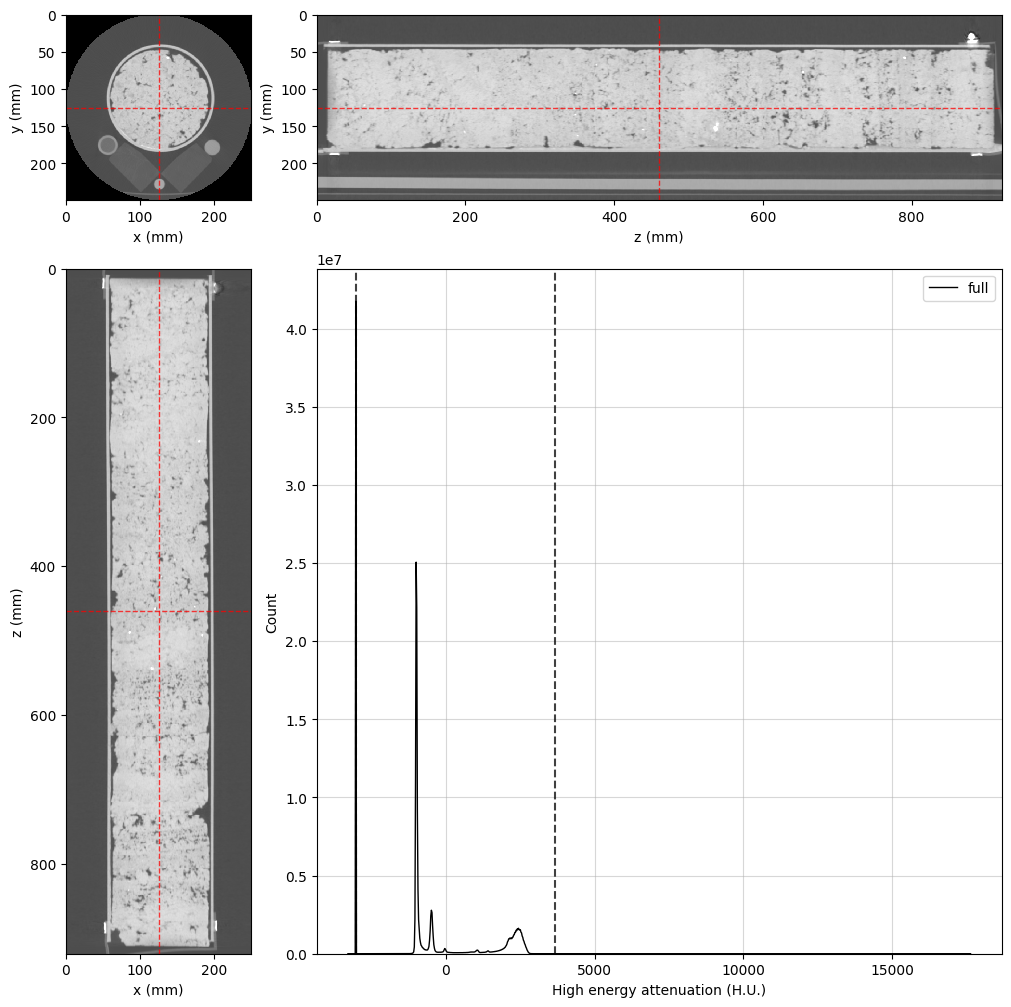

In [3]:
%%px --block

# Create orthogonal viewers for low and high energy images
lowE_viewer = rv.OrthogonalViewer(image=dectgroup.lowECT, histogram_bins=2**10)
highE_viewer = rv.OrthogonalViewer(image=dectgroup.highECT, histogram_bins=2**10)

# Matplotlib's figure object can be accessed through
# the figure property in the orthogonal viewer.
# Let's increase the figure size
lowE_viewer.figure.set_size_inches(10, 10)
highE_viewer.figure.set_size_inches(10, 10)

# Each process will create its own repeated image,
# let's close all but rank zero:
if rv.config.mpi_rank != 0:
    plt.close(lowE_viewer.figure)
    plt.close(highE_viewer.figure)

## Build the Segmentation Image

A segmentation image will inform RockVerse about the spatial location 
of the standard materials for histogram calculations. 
We could use the `copy_image` method to bring the segmentation image
into the `dectgroup`, similar to what we did with the X-ray tomograms 
(see the API documentation for details), but the segmentation image is not 
available in the original dataset from the Digital Rocks Portal.

Nevertheless, the rock sample and the standard materials are fairly aligned 
with the image's z-axis. Let's quickly build a (not very accurate but 
still useful...) segmentation image using RockVerse's cylindrical 
regions.

A little trial and error is all it takes in this case:

### Air Region

%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[stdout:0] [2025-02-25 13:56:28] Histogram High energy attenuation (min/max): 100% 16/16 [00:00<00:00, 25.30chunk/s]
[2025-02-25 13:56:28] Histogram High energy attenuation (counting voxels): 100% 16/16 [00:00<00:00, 65.46chunk/s]


[output:0]

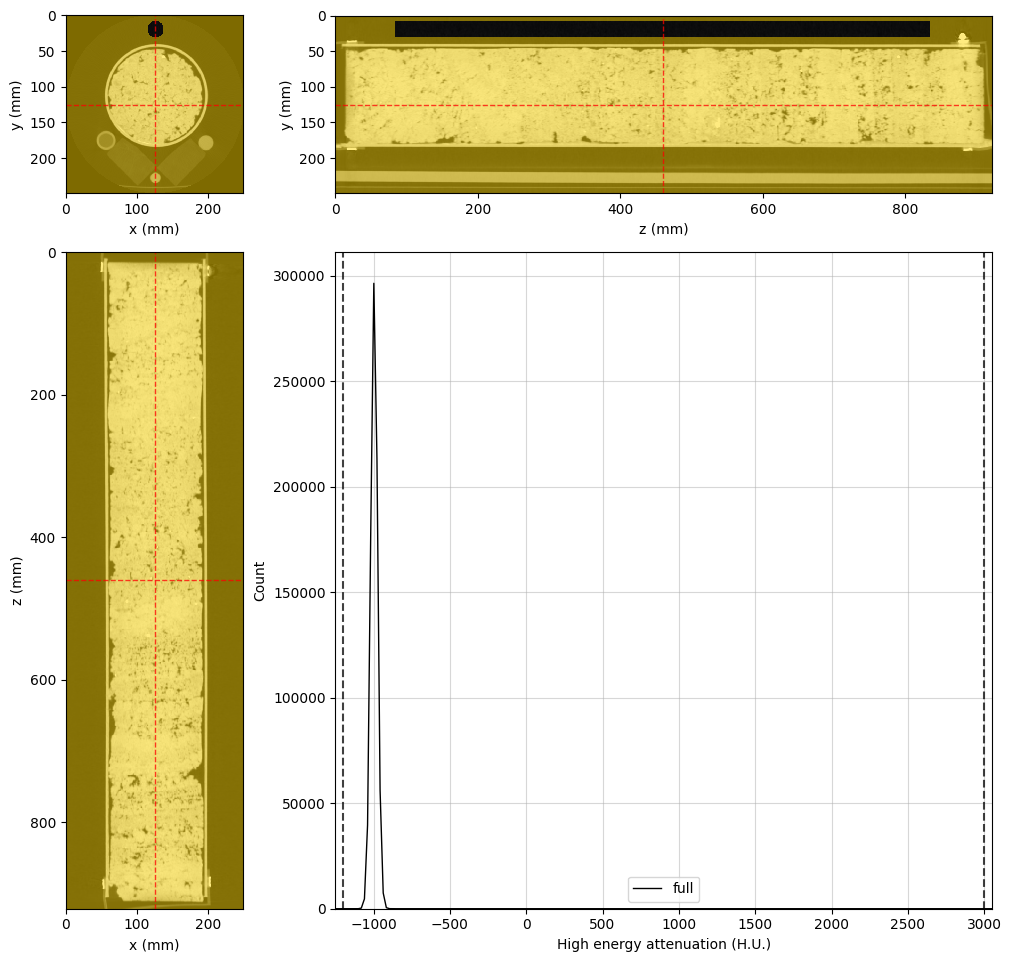

In [4]:
%%px --block

# Adjusting viewer properties will help us in this task
highE_viewer.update_image_dict(clim=(-1200, 3000))
highE_viewer.mask_color = 'gold'
highE_viewer.mask_alpha = 0.5

# This is the final cylindrical region for probing air attenuation
air_region = rv.region.Cylinder(p=(126, 20, 461), v=(0, 0, 1), r=10, l=750)

# Set the region in the viewer and visualize the result
highE_viewer.region = air_region

# Changing region rebuilds the histogram. Let's set the scale again
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

# Only display the figure for rank 0
if rv.config.mpi_rank == 0:
    display(highE_viewer.figure)

### Water region

[stdout:0] [2025-02-25 13:56:42] Histogram High energy attenuation (min/max): 100% 16/16 [00:00<00:00, 29.72chunk/s]
[2025-02-25 13:56:43] Histogram High energy attenuation (counting voxels): 100% 16/16 [00:00<00:00, 67.74chunk/s]


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[output:0]

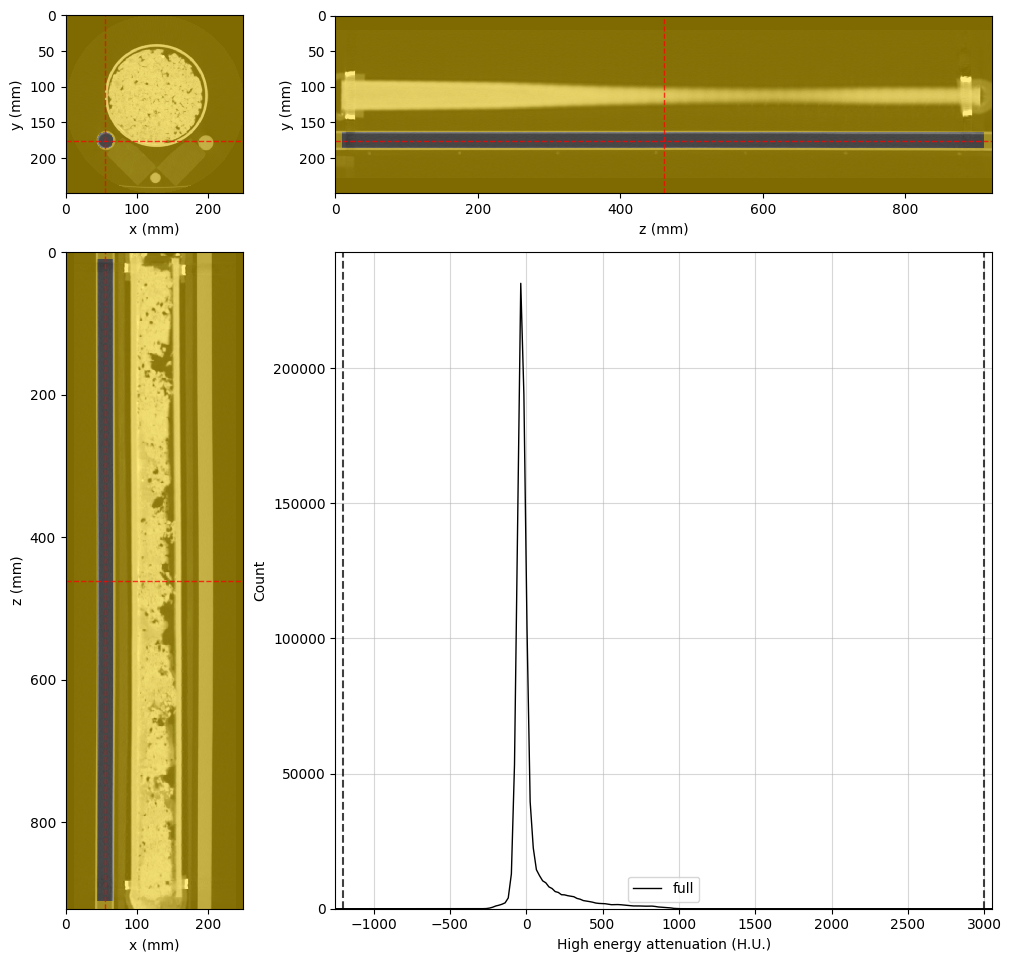

In [5]:
%%px --block

# Final water region
water_region = rv.region.Cylinder(p=(55, 176.2, 461), v=(0, 0, 1), r=10, l=900)

# Adjust the viewer and display for rank 0
highE_viewer.region = water_region
highE_viewer.ref_point = water_region.p
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

if rv.config.mpi_rank == 0:
    display(highE_viewer.figure)

### Silica region

[stdout:0] [2025-02-25 13:56:52] Histogram High energy attenuation (min/max): 100% 16/16 [00:00<00:00, 22.54chunk/s]
[2025-02-25 13:56:52] Histogram High energy attenuation (counting voxels): 100% 16/16 [00:00<00:00, 69.70chunk/s]


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[output:0]

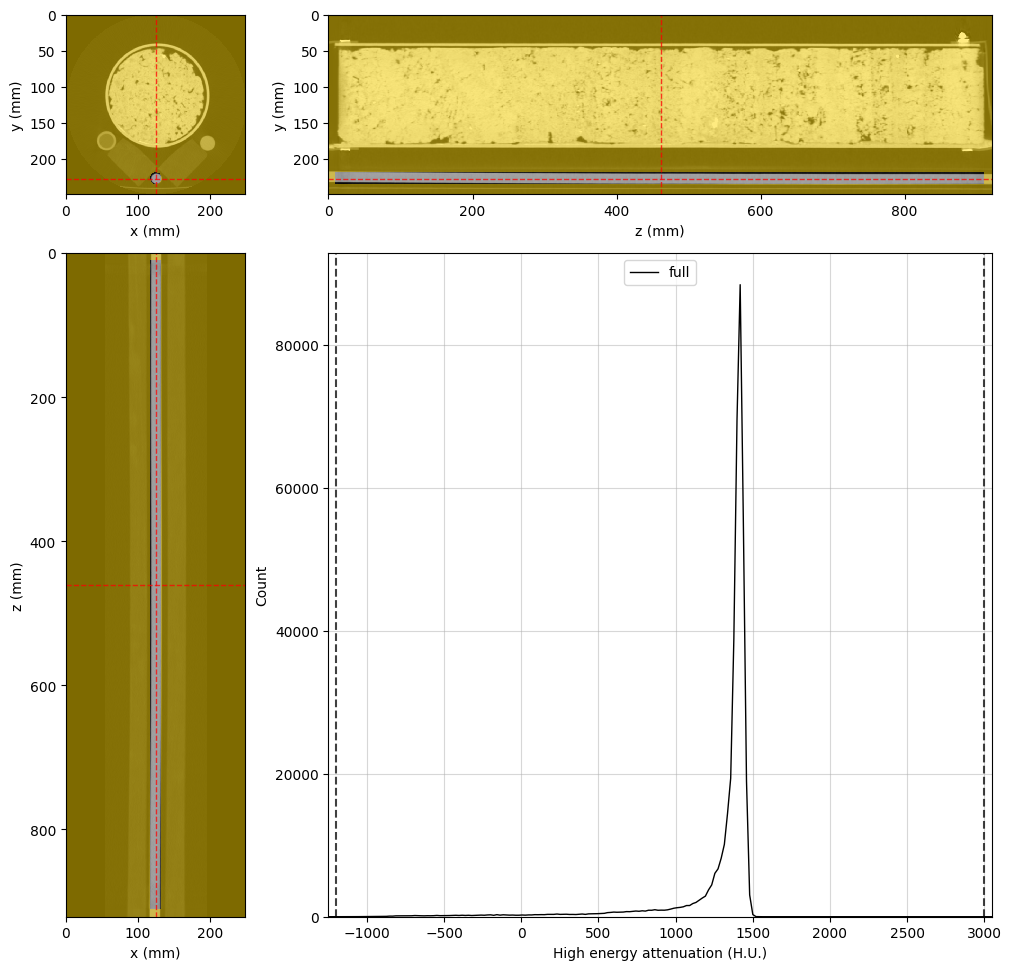

In [6]:
%%px --block

# Final silica region
silica_region = rv.region.Cylinder(p=(124.7, 228, 461), v=(0, 0, 1), r=6.5, l=900)

# Adjust the viewer and display for rank 0
highE_viewer.region = silica_region
highE_viewer.ref_point = silica_region.p
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

if rv.config.mpi_rank == 0:
    display(highE_viewer.figure)

### Teflon region

[stdout:0] [2025-02-25 13:57:04] Histogram High energy attenuation (min/max): 100% 16/16 [00:00<00:00, 29.13chunk/s]
[2025-02-25 13:57:05] Histogram High energy attenuation (counting voxels): 100% 16/16 [00:00<00:00, 65.84chunk/s]


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[output:0]

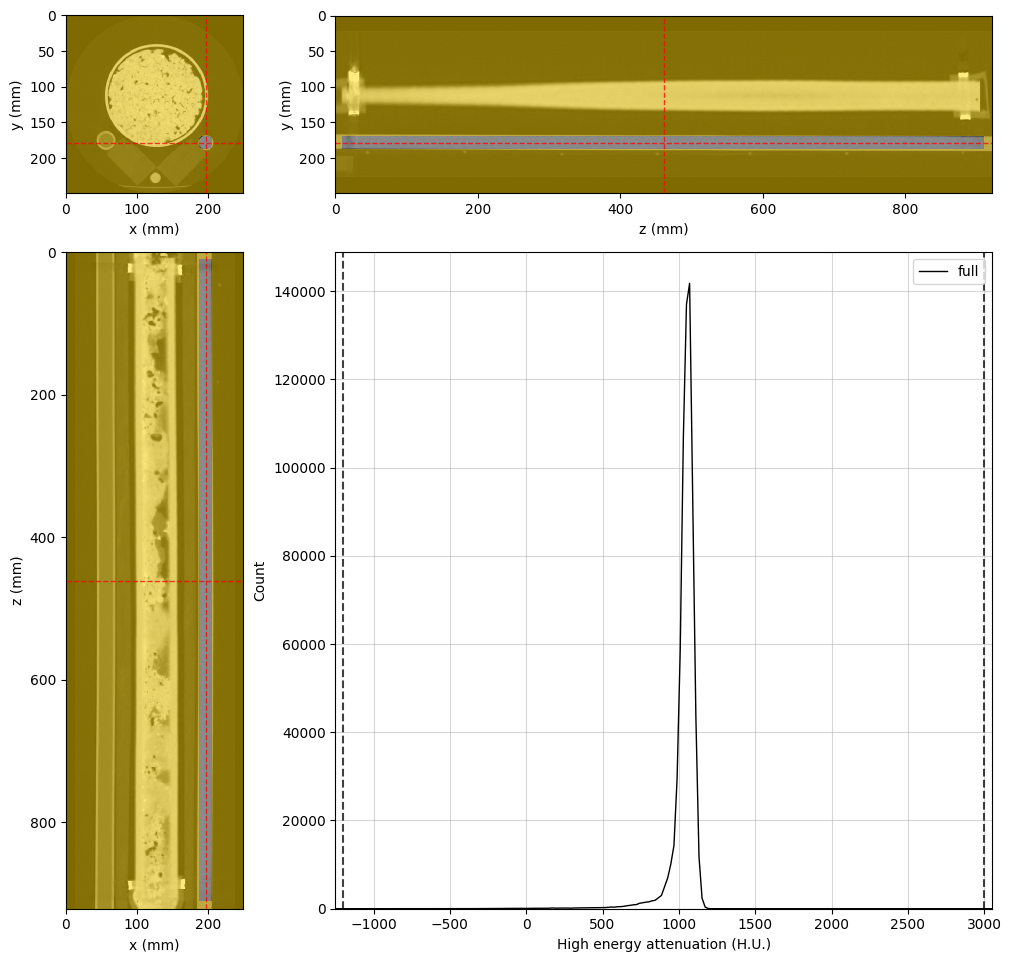

In [7]:
%%px --block

# Final teflon region
teflon_region = rv.region.Cylinder(p=(196, 179, 461), v=(0, 0, 1), r=8.5, l=900)

# Adjust the viewer and display for rank 0
highE_viewer.region = teflon_region
highE_viewer.ref_point = teflon_region.p
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

if rv.config.mpi_rank == 0:
    display(highE_viewer.figure)

### Rock sample region

[stdout:0] [2025-02-25 13:57:33] Histogram High energy attenuation (min/max): 100% 16/16 [00:00<00:00, 21.60chunk/s]
[2025-02-25 13:57:34] Histogram High energy attenuation (counting voxels): 100% 16/16 [00:00<00:00, 18.35chunk/s]


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[output:0]

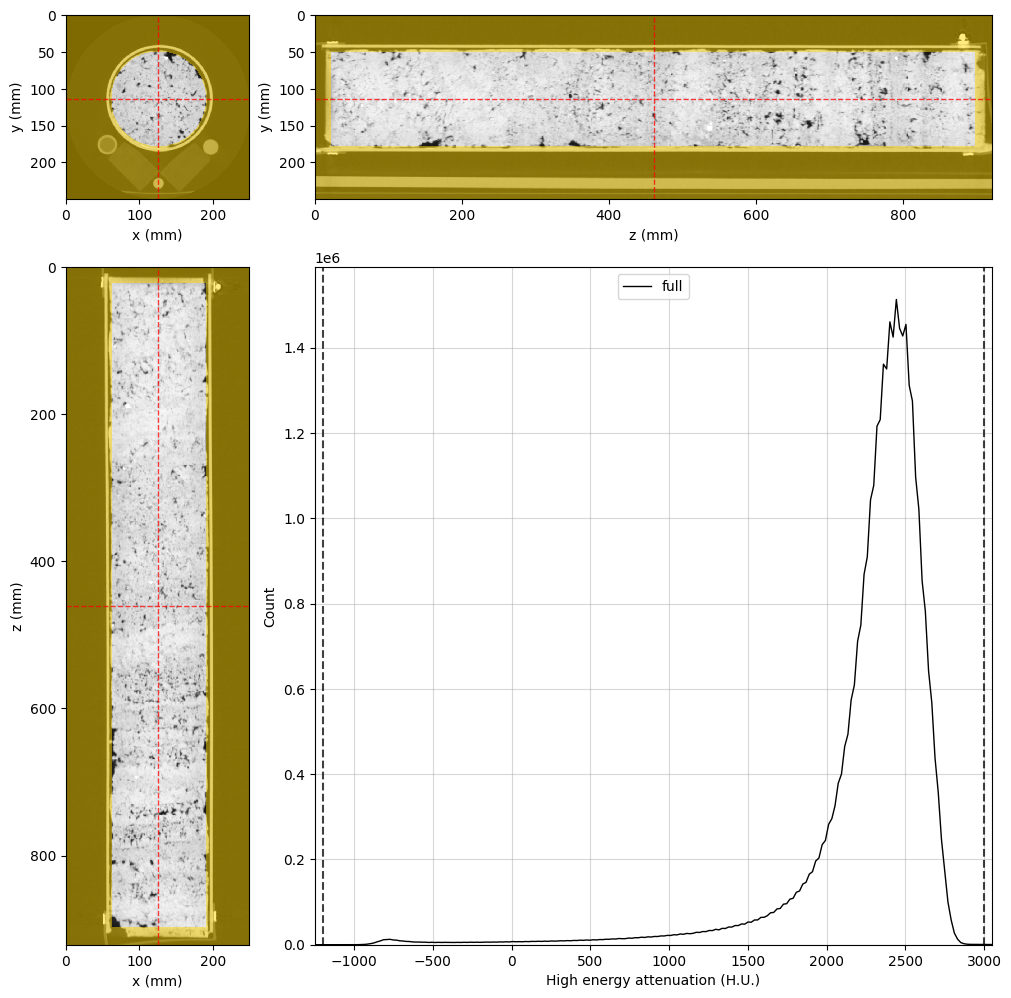

In [8]:
%%px --block --group-outputs=type

# Final rock region
rock_region = rv.region.Cylinder(p=(126, 114, 461), v=(0, 0, 1), r=63, l=875)

# Adjust the viewer and display for rank 0
highE_viewer.region = rock_region
highE_viewer.ref_point = rock_region.p
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

if rv.config.mpi_rank == 0:
    display(highE_viewer.figure)

### Combined segmentation image

Now, we can use these regions to create the final segmentation image:

[stdout:0] [2025-02-25 13:57:51] (segmentation) Set: 100% 16/16 [00:03<00:00,  5.14chunk/s]
[2025-02-25 13:57:56] (segmentation) Set: 100% 16/16 [00:00<00:00, 45.65chunk/s]
[2025-02-25 13:57:57] (segmentation) Set: 100% 16/16 [00:00<00:00, 45.27chunk/s]
[2025-02-25 13:57:57] (segmentation) Set: 100% 16/16 [00:00<00:00, 43.11chunk/s]
[2025-02-25 13:57:58] (segmentation) Set: 100% 16/16 [00:00<00:00, 43.85chunk/s]
[2025-02-25 13:57:59] Histogram High energy attenuation (min/max): 100% 16/16 [00:00<00:00, 98.43chunk/s]
[2025-02-25 13:57:59] Histogram High energy attenuation (counting voxels): 100% 16/16 [00:01<00:00,  9.39chunk/s]
[2025-02-25 13:58:03] Histogram High energy attenuation (min/max): 100% 16/16 [00:00<00:00, 100.84chunk/s]
[2025-02-25 13:58:03] Histogram High energy attenuation (reading segmentation): 100% 16/16 [00:00<00:00, 107.16chunk/s]
[2025-02-25 13:58:03] Histogram High energy attenuation (counting voxels): 100% 16/16 [00:02<00:00,  7.58chunk/s]


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[output:0]

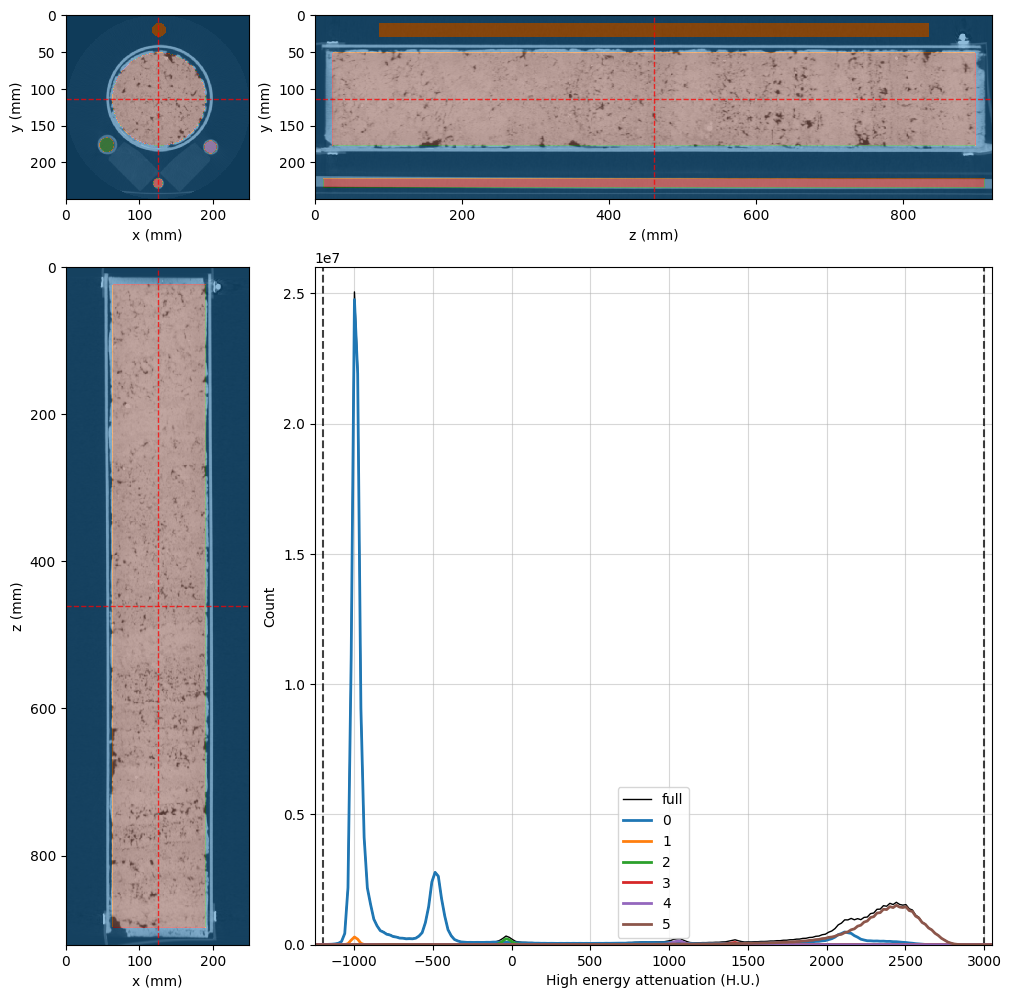

In [9]:
%%px --block

# Create the segmentation voxel image inside the dual energy group
dectgroup.create_segmentation(fill_value=0, overwrite=True)

# Use the VoxelImage math method to assign each region
dectgroup.segmentation.math(value=1, op='set', region=air_region)     # Air will be phase 1
dectgroup.segmentation.math(value=2, op='set', region=water_region)   # Water will be phase 2
dectgroup.segmentation.math(value=3, op='set', region=silica_region)  # Silica will be phase 3
dectgroup.segmentation.math(value=4, op='set', region=teflon_region)  # Teflon will be phase 4
dectgroup.segmentation.math(value=5, op='set', region=rock_region)    # Rock sample will be phase 5

# Adjust the viewer and display for rank 0
highE_viewer.region = None
highE_viewer.segmentation = dectgroup.segmentation
highE_viewer.ref_point = rock_region.p
highE_viewer.ax_histogram.set_xlim(-1250, 3050)
highE_viewer.ax_histogram.set_ylim(0, 2.6e7)

if rv.config.mpi_rank == 0:
    display(highE_viewer.figure)

## Build the Mask Image

Now let's define an image mask to save time in the Monte Carlo inversion by masking out voxels for which we are not interested in the results. While we cannot assign RockVerse regions of interest to DualEnergyCT groups, we can create an arbitrary mask voxel image to inform RockVerse which voxels should be ignored.

If you have a mask image somewhere, you can import it into the ``dualenergyct`` group using the ``copy_image`` method. In our case, phase 0 in our segmentation image represents the regions we want to exclude from our inversion, so the ``create_mask`` method is all we need:

[stdout:0] [2025-02-25 13:58:40] (mask) Set: 100% 16/16 [00:00<00:00, 28.40chunk/s]
[2025-02-25 13:58:41] Histogram High energy attenuation (min/max): 100% 16/16 [00:00<00:00, 40.46chunk/s]
[2025-02-25 13:58:41] Histogram High energy attenuation (reading segmentation): 100% 16/16 [00:00<00:00, 442.80chunk/s]
[2025-02-25 13:58:41] Histogram High energy attenuation (counting voxels): 100% 16/16 [00:00<00:00, 17.81chunk/s]


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[output:0]

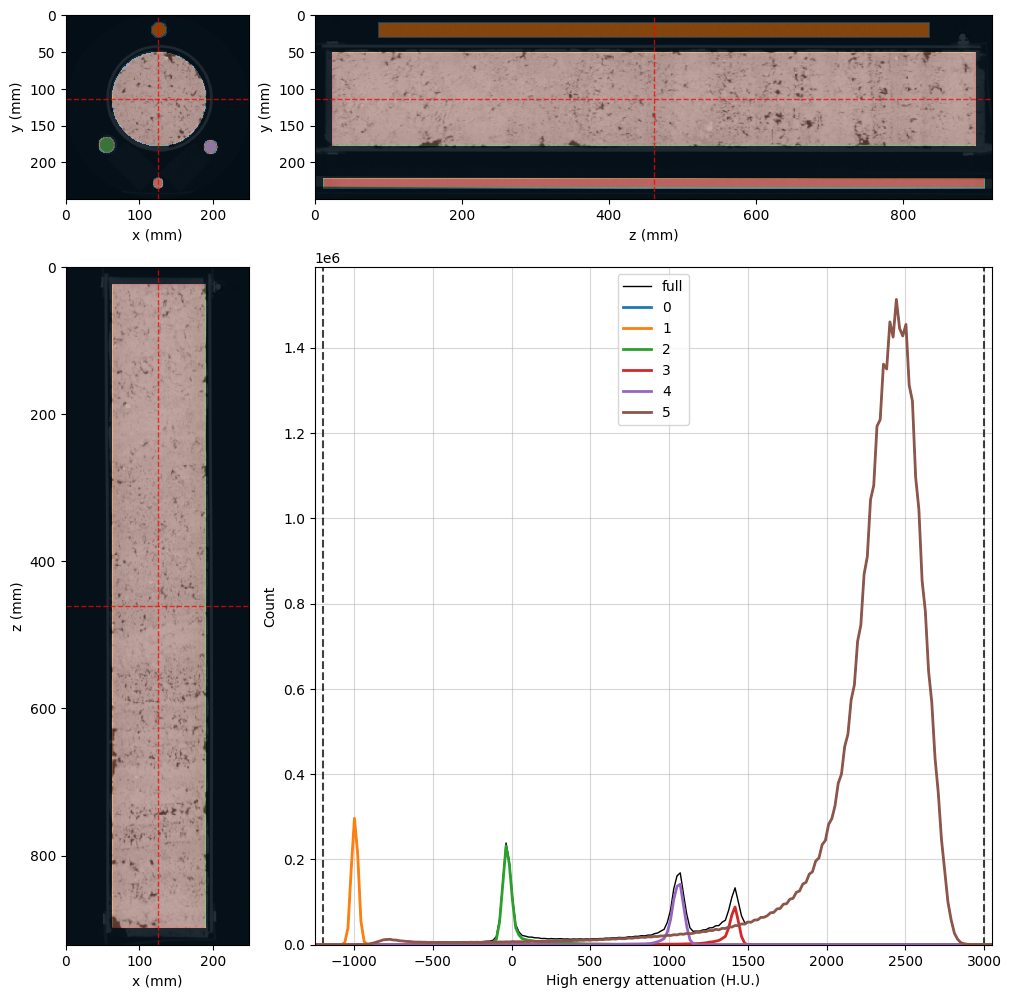

In [10]:
%%px --block

# Create the empty mask
dectgroup.create_mask(fill_value=False, overwrite=True)

# Use VoxelImage math method to set mask to True where segmentation is 0
dectgroup.mask.math(value=True,
                    op='set',
                    segmentation=dectgroup.segmentation,
                    phases=(0,))

# Adjust the viewer and display for rank 0
highE_viewer.mask = dectgroup.mask
highE_viewer.mask_color = 'k'
highE_viewer.mask_alpha = 0.75
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

if rv.config.mpi_rank == 0:
    display(highE_viewer.figure)


The black voxels in the image above will be ignored during the Monte Carlo inversion. Let's rebuild both viewers with all the updates so far:

[stdout:0] [2025-02-25 13:58:59] Histogram Low energy attenuation (min/max): 100% 16/16 [00:00<00:00, 62.48chunk/s]
[2025-02-25 13:58:59] Histogram Low energy attenuation (reading segmentation): 100% 16/16 [00:00<00:00, 392.42chunk/s]
[2025-02-25 13:58:59] Histogram Low energy attenuation (counting voxels): 100% 16/16 [00:00<00:00, 17.44chunk/s]
[2025-02-25 13:59:03] Histogram High energy attenuation (min/max): 100% 16/16 [00:00<00:00, 63.23chunk/s]
[2025-02-25 13:59:03] Histogram High energy attenuation (reading segmentation): 100% 16/16 [00:00<00:00, 441.67chunk/s]
[2025-02-25 13:59:03] Histogram High energy attenuation (counting voxels): 100% 16/16 [00:00<00:00, 18.21chunk/s]


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[output:0]

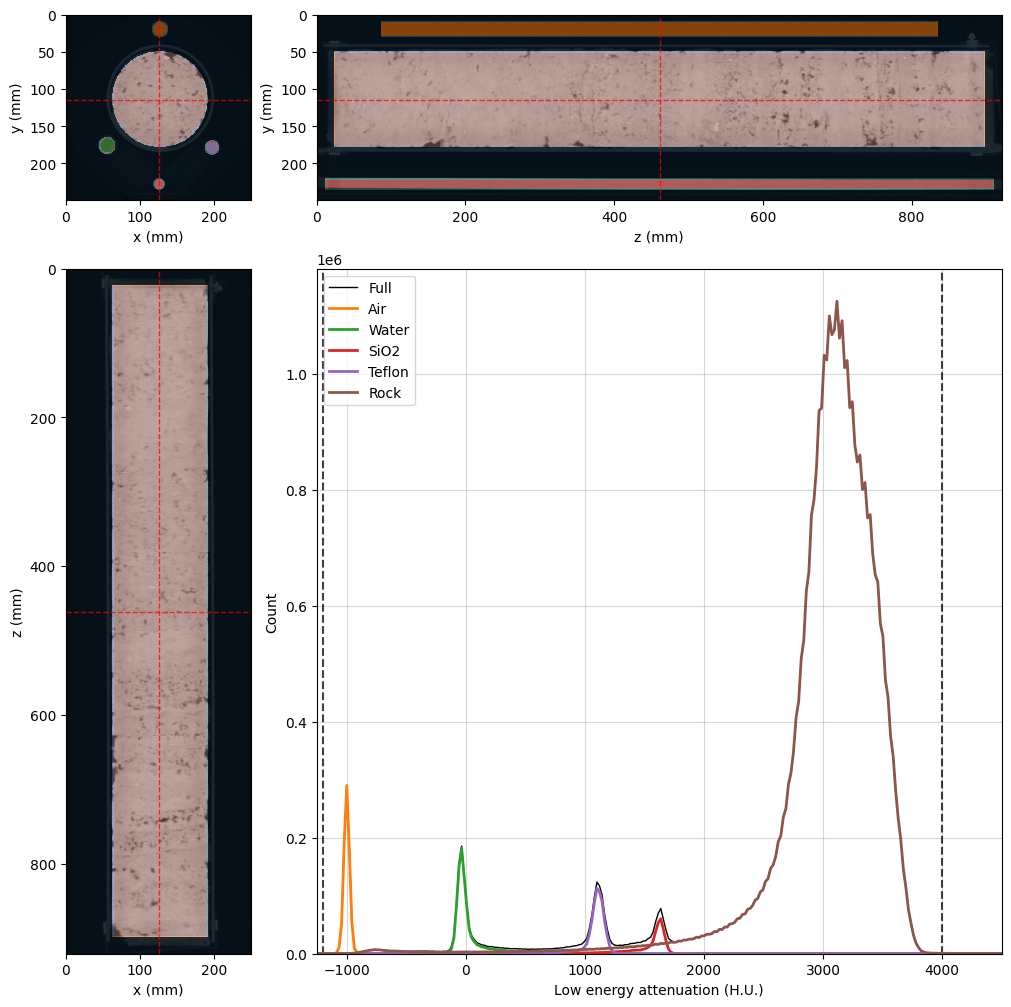

[output:0]

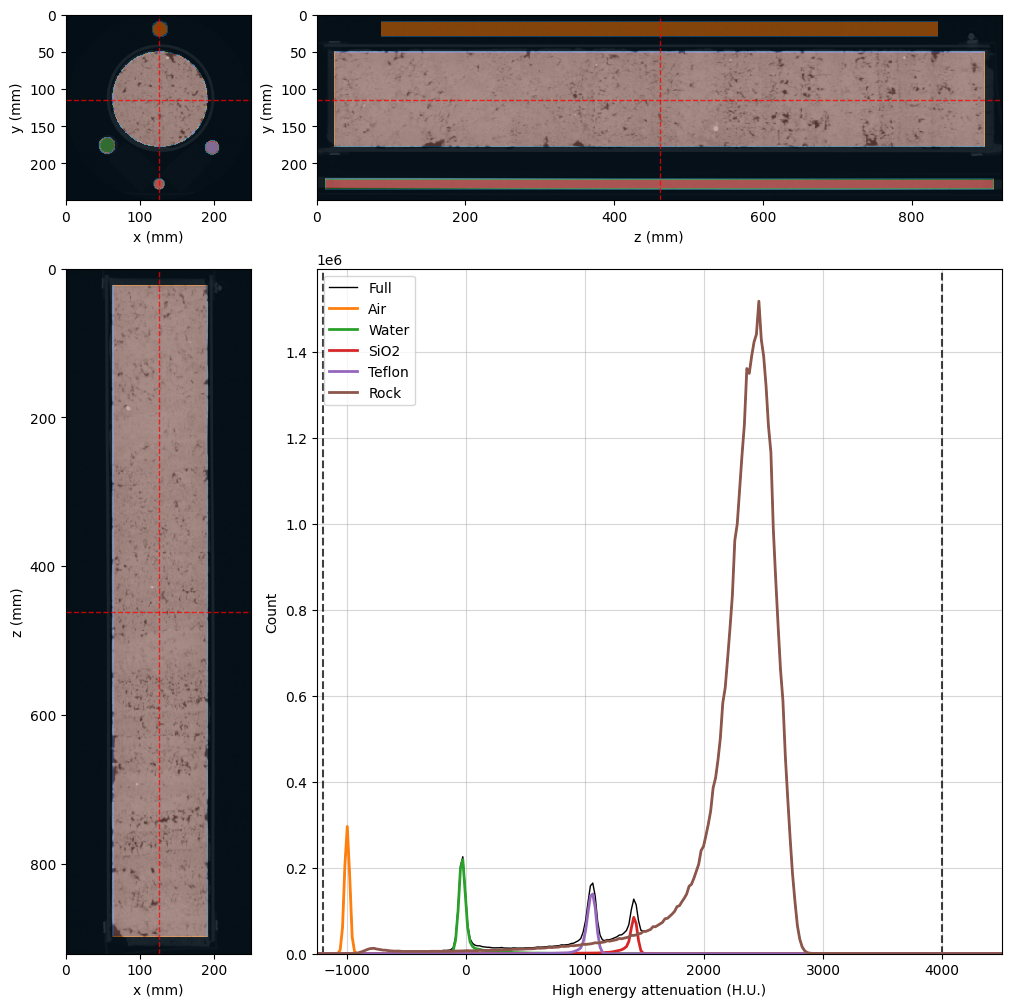

In [11]:
%%px --block

# Common properties can be set at once at OrthogonalViewer creation
kwargs = {
    'region': None,
    'mask': dectgroup.mask,
    'mask_color': 'k',
    'mask_alpha': 0.75,
    'histogram_bins': 2**10,
    'segmentation': dectgroup.segmentation,
    'ref_point': rock_region.p,
}

lowE_viewer = rv.OrthogonalViewer(image=dectgroup.lowECT, **kwargs)
highE_viewer = rv.OrthogonalViewer(image=dectgroup.highECT, **kwargs)

# Fine tuning viewer properties
for viewer in [lowE_viewer, highE_viewer]:
    viewer.figure.set_size_inches(10, 10)    # figure size
    viewer.update_image_dict(clim=(-1200, 4000)) # X-ray CT clims
    viewer.ax_histogram.set_xlim(-1250, 4500)  # Histogram limits
    # Set segmentation names in the legend labels
    viewer.ax_histogram.legend(
        [
            highE_viewer.histogram_lines['full'],
            highE_viewer.histogram_lines['1'],
            highE_viewer.histogram_lines['2'],
            highE_viewer.histogram_lines['3'],
            highE_viewer.histogram_lines['4'],
            highE_viewer.histogram_lines['5'],
        ], [
            'Full',
            'Air',
            'Water',
            'SiO2',
            'Teflon',
            'Rock'
        ]
    )

# Close all but rank 0
if rv.config.mpi_rank != 0:
    plt.close(lowE_viewer.figure)
    plt.close(highE_viewer.figure)


## Fill Standard Material Information

The final step in data preparation is to populate the information and the X-ray attenuation probability density functions (PDFs) for the standard materials. The PDFs must be passed as a two-element list or tuple containing the x (attenuation values) and y (PDF values) arrays for the PDF model. PDF values do not need to be normalized, as RockVerse will handle the normalization when assigning the values.

While we could simply use the histogram values available in the orthogonal viewers, we'll model a Gaussian distribution after each segmentation histogram to filter out spurious values and border voxels due to our lazy segmentation in this tutorial. We'll use the RockVerse optimization module for this task.

### Air

[output:0]

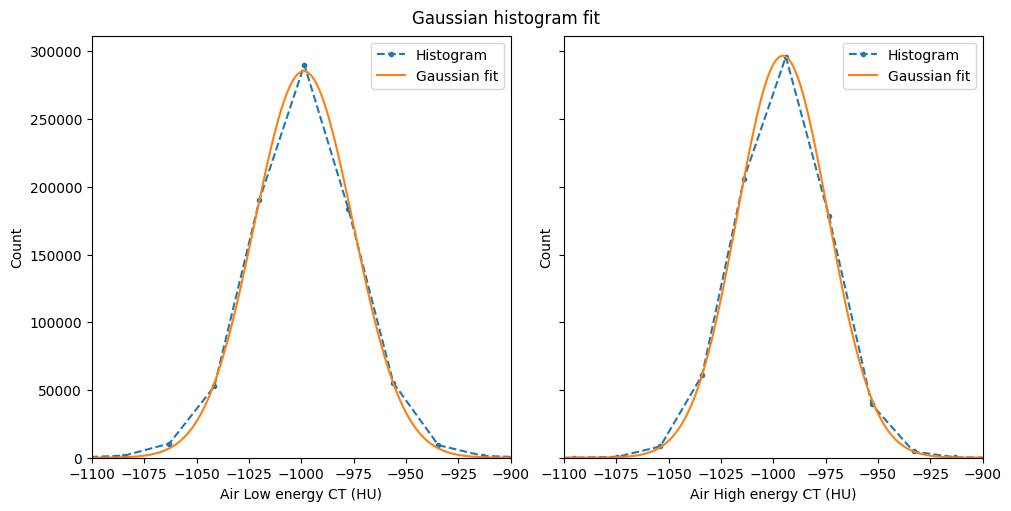

In [12]:
%%px --block

import numpy as np
from rockverse.optimize import gaussian_fit, gaussian_val

# Retrieve the values from orthogonal viewers' histograms
# Air is segmentation phase 1
x_low = lowE_viewer.histogram.bin_centers
y_low = lowE_viewer.histogram.count[1].values
x_high = highE_viewer.histogram.bin_centers
y_high = highE_viewer.histogram.count[1].values

# Call gaussian_fit to get fitting parameters
c_low = gaussian_fit(x_low, y_low)
c_high = gaussian_fit(x_high, y_high)

# Build a fine-spaced histogram axis and call
# gaussian_val to build the Gaussian curve.
xlim = (-1100, -900)
x_fit = np.linspace(*xlim, 200)
y_fit_low = gaussian_val(c_low, x_fit)
y_fit_high = gaussian_val(c_high, x_fit)

# Check the Gaussian fit:
if mpi_rank == 0:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5),
                            layout='constrained',
                            sharex=True, sharey=True)
    fig.suptitle('Gaussian histogram fit')

    for k, (x, y, yfit, E) in enumerate(zip((x_low, x_high),
                                             (y_low, y_high),
                                             (y_fit_low, y_fit_high),
                                             ('Low', 'High'))):

        ax[k].plot(x, y, '.--', label='Histogram')
        ax[k].plot(x_fit, yfit, '-', label='Gaussian fit')
        ax[k].set_xlabel(f'Air {E} energy CT (HU)')
        ax[k].set_xlim(xlim)
        ax[k].legend()
        ax[k].set_ylabel('Count')
    ax[0].set_ylim(ymin=0)

# Finally fill in necessary fields in dectgroup
# Standard material 0 is empty space
# Note: setting or getting PDFs is a collective MPI call,
# make sure all the processes run it (e.g. don't use if 'mpi_rank == 0')
dectgroup.calibration_material[0].description = 'Air'
dectgroup.calibration_material[0].lowE_pdf = (x_fit, y_fit_low)
dectgroup.calibration_material[0].highE_pdf = (x_fit, y_fit_high)

Now let's replicate to the other standard materials.

### Water

[output:0]

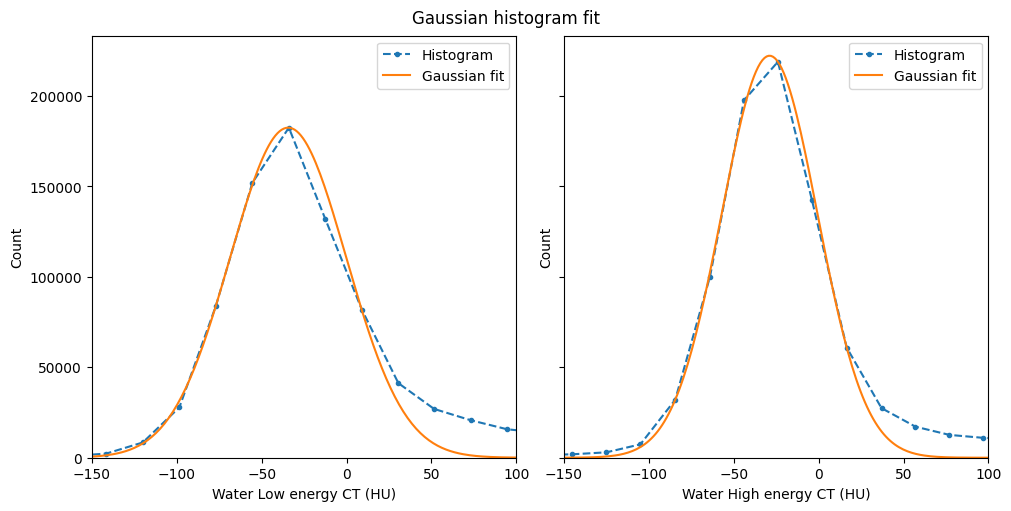

In [13]:
%%px --block

# Retrieve the values from orthogonal viewers' histograms
# Water is segmentation phase 2
x_low = lowE_viewer.histogram.bin_centers
y_low = lowE_viewer.histogram.count[2].values
x_high = highE_viewer.histogram.bin_centers
y_high = highE_viewer.histogram.count[2].values

# Call gaussian_fit to get fitting parameters
c_low = gaussian_fit(x_low, y_low)
c_high = gaussian_fit(x_high, y_high)

# Build a fine-spaced histogram axis and call
# gaussian_val to build the gaussian curve.
# It is important sample regions
# with PDF values close to zero
xlim = (-150, 100)
x_fit = np.linspace(*xlim, 200)
y_fit_low = gaussian_val(c_low, x_fit)
y_fit_high = gaussian_val(c_high, x_fit)

# Let's check the Gaussian fit:
if mpi_rank == 0:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5),
                           layout='constrained',
                           sharex=True, sharey=True)
    fig.suptitle('Gaussian histogram fit')

    for k, (x, y, yfit, E) in enumerate(zip((x_low, x_high),
                                            (y_low, y_high),
                                            (y_fit_low, y_fit_high),
                                            ('Low', 'High'))):

        ax[k].plot(x, y, '.--', label='Histogram')
        ax[k].plot(x_fit, yfit, '-', label='Gaussian fit')
        ax[k].set_xlabel(f'Water {E} energy CT (HU)')
        ax[k].set_xlim(xlim)
        ax[k].legend()
        ax[k].set_ylabel('Count')
    ax[0].set_ylim(ymin=0)

# Now fill in necessary fields in dectgroup
# We'll assign water to calibration material 1
# Note: setting or getting PDFs is a collective MPI call,
# make sure all the processes run it (e.g. don't use if 'mpi_rank == 0')
dectgroup.calibration_material[1].description = 'Water'
dectgroup.calibration_material[1].lowE_pdf = (x_fit, y_fit_low)
dectgroup.calibration_material[1].highE_pdf = (x_fit, y_fit_high)
dectgroup.calibration_material[1].bulk_density = 1.0
dectgroup.calibration_material[1].composition = {'H': 2, 'O': 1}

### Silica

[output:0]

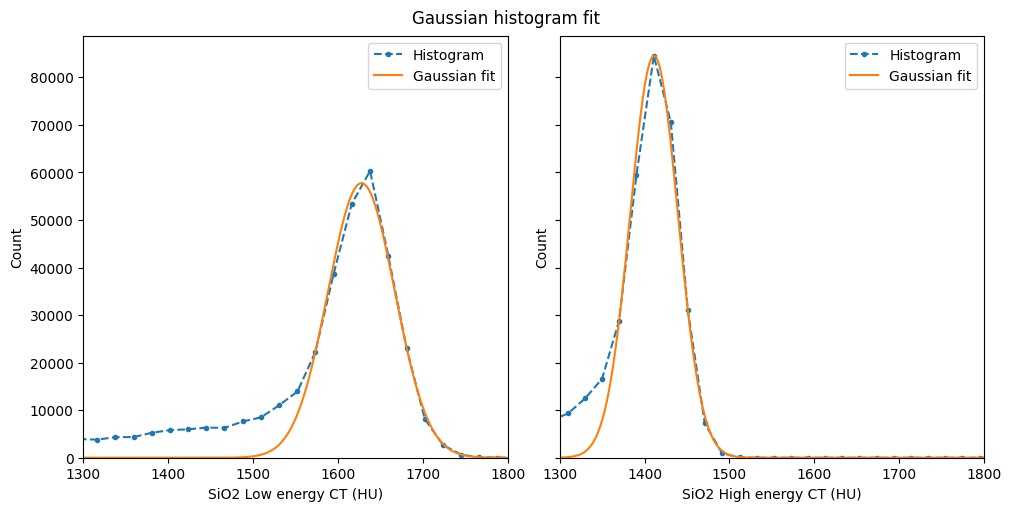

In [14]:
%%px --block

# Retrieve the values from orthogonal viewers' histograms
# Silica is segmentation phase 3
x_low = lowE_viewer.histogram.bin_centers
y_low = lowE_viewer.histogram.count[3].values
x_high = highE_viewer.histogram.bin_centers
y_high = highE_viewer.histogram.count[3].values

# Call gaussian_fit to get fitting parameters
c_low = gaussian_fit(x_low, y_low)
c_high = gaussian_fit(x_high, y_high)

# Build a fine-spaced histogram axis and call
# gaussian_val to build the gaussian curve.
# It is important to sample regions
# with PDF values close to zero
xlim = (1300, 1800)
x_fit = np.linspace(*xlim, 200)
y_fit_low = gaussian_val(c_low, x_fit)
y_fit_high = gaussian_val(c_high, x_fit)

# Let's check the Gaussian fit:
if mpi_rank == 0:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5),
                           layout='constrained',
                           sharex=True, sharey=True)
    fig.suptitle('Gaussian histogram fit')

    for k, (x, y, yfit, E) in enumerate(zip((x_low, x_high),
                                            (y_low, y_high),
                                            (y_fit_low, y_fit_high),
                                            ('Low', 'High'))):

        ax[k].plot(x, y, '.--', label='Histogram')
        ax[k].plot(x_fit, yfit, '-', label='Gaussian fit')
        ax[k].set_xlabel(f'SiO2 {E} energy CT (HU)')
        ax[k].set_xlim(xlim)
        ax[k].legend()
        ax[k].set_ylabel('Count')
    ax[0].set_ylim(ymin=0)

# Now fill in necessary fields in dectgroup
# We'll assign silica to calibration material 2
# Note: setting or getting PDFs is a collective MPI call,
# make sure all the processes run it (e.g. don't use if 'mpi_rank == 0')
dectgroup.calibration_material[2].description = 'SiO2'
dectgroup.calibration_material[2].lowE_pdf = (x_fit, y_fit_low)
dectgroup.calibration_material[2].highE_pdf = (x_fit, y_fit_high)
dectgroup.calibration_material[2].bulk_density = 2.2
dectgroup.calibration_material[2].composition = {'Si': 1, 'O': 2}

### Teflon

[output:0]

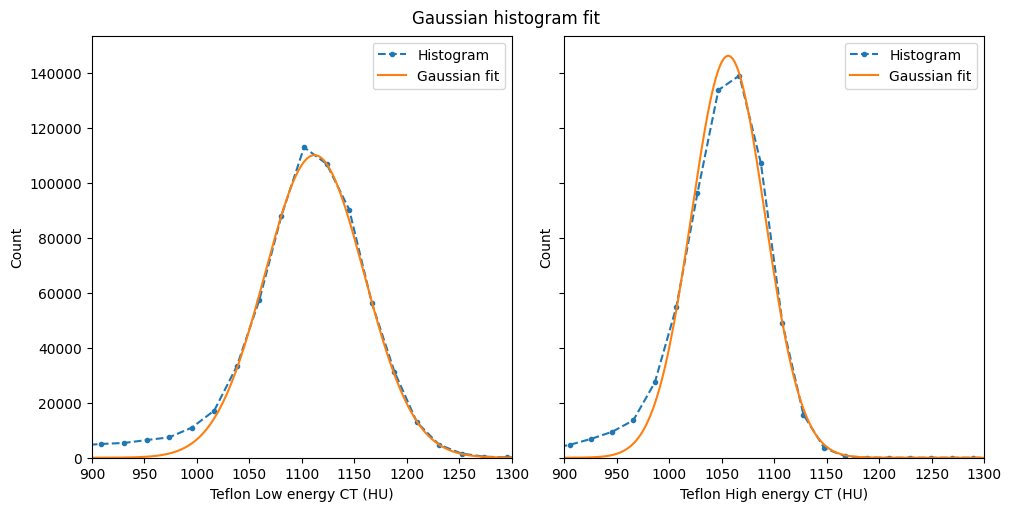

In [15]:
%%px --block

# Retrieve the values from orthogonal viewers' histograms
# Teflon is segmentation phase 4
x_low = lowE_viewer.histogram.bin_centers
y_low = lowE_viewer.histogram.count[4].values
x_high = highE_viewer.histogram.bin_centers
y_high = highE_viewer.histogram.count[4].values

# Call gaussian_fit to get fitting parameters
c_low = gaussian_fit(x_low, y_low)
c_high = gaussian_fit(x_high, y_high)

# Build a fine-spaced histogram axis and call
# gaussian_val to build the gaussian curve.
# It is important to sample regions
# with PDF values close to zero
xlim = (900, 1300)
x_fit = np.linspace(*xlim, 200)
y_fit_low = gaussian_val(c_low, x_fit)
y_fit_high = gaussian_val(c_high, x_fit)

#Let's check the Gaussian fit:
if mpi_rank == 0:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5),
                           layout='constrained',
                           sharex=True, sharey=True)
    fig.suptitle('Gaussian histogram fit')

    for k, (x, y, yfit, E) in enumerate(zip((x_low, x_high),
                                            (y_low, y_high),
                                            (y_fit_low, y_fit_high),
                                            ('Low', 'High'))):

        ax[k].plot(x, y, '.--', label='Histogram')
        ax[k].plot(x_fit, yfit, '-', label='Gaussian fit')
        ax[k].set_xlabel(f'Teflon {E} energy CT (HU)')
        ax[k].set_xlim(xlim)
        ax[k].legend()
        ax[k].set_ylabel('Count')
    ax[0].set_ylim(ymin=0)

# Now fill in necessary fields in dectgroup
# We'll assign teflon to calibration material 3
# Note: setting or getting PDFs is a collective MPI call,
# make sure all the processes run it (e.g. don't use if 'mpi_rank == 0')
dectgroup.calibration_material[3].description = 'Teflon'
dectgroup.calibration_material[3].lowE_pdf = (x_fit, y_fit_low)
dectgroup.calibration_material[3].highE_pdf = (x_fit, y_fit_high)
dectgroup.calibration_material[3].bulk_density = 2.2
dectgroup.calibration_material[3].composition = {'C': 2, 'F': 4}

## Run the Preprocessing Step

Pre-processing will check all the necessary details in the `dectgroup` and pre-calculate the dual energy inversion coefficients $A$, $B$, and $n$ for low and high energy. Additionally, this step verifies all the internal hash values to ensure simulation integrity, which is crucial for resuming any interrupted simulations.

The simulations are controlled by the following parameters:
- `maxA`: Maximum search value for inversion coefficient $A$. 
- `maxB`: Maximum search value for inversion coefficient $B$.
- `maxn`: Maximum value for inversion coefficient $n$.
- `tol`: Tolerance value for terminating the Newton-Raphson optimizations.
- `whis`: The boxplot whisker length for determining Monte Carlo outlier results.
- `required_iterations`: The required number of valid Monte Carlo iterations for each voxel.
- `maximum_iterations`: The maximum number of trials to get valid Monte Carlo iterations per voxel.
- `threads_per_block`: The number of threads per block when processing using GPUs, which can optimize performance based on available hardware.

RockVerse has default values for these parameters, which you can get or set using the corresponding properties (see the API documentation for more details):
- `dectgroup.maxA`
- `dectgroup.maxB`
- `dectgroup.maxn`
- `dectgroup.tol`
- `dectgroup.whis`
- `dectgroup.required_iterations`
- `dectgroup.maximum_iterations`
- `dectgroup.threads_per_block`

Let's call the ``preprocess`` method:

In [16]:
%%px --block

# Run the preprocessing step to check structure details and calculate inversion coefficients
dectgroup.preprocess()

[stdout:0] [2025-02-25 14:01:28] Hashing Low energy attenuation: 100% 16/16 [00:00<00:00, 71.43chunk/s]
[2025-02-25 14:01:29] Hashing High energy attenuation: 100% 16/16 [00:00<00:00, 71.73chunk/s]
[2025-02-25 14:01:29] Hashing mask: 100% 16/16 [00:00<00:00, 205.16chunk/s]
[2025-02-25 14:01:29] Hashing segmentation: 100% 16/16 [00:00<00:00, 210.19chunk/s]
[2025-02-25 14:01:40] Generating inversion coefficients: 100% 100000/100000 [00:02<00:00, 45678.00/s]


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

Now that the data is ready, we can stop the cluster.

In [17]:
cluster.stop_cluster()

<coroutine object Cluster.stop_cluster at 0x7f48d674f2a0>

### Appraisal

As the last part of this tutorial, let's check the generated coefficients. We will do this locally now (notice that we are no longer using the `%%px` magic). Therefore, we need to import the necessary libraries and the dual energy group in the local kernel:

In [ ]:
import matplotlib.pyplot as plt
import rockverse as rv

# Open the group
dectgroup = rv.open('/path/to/dual_energy_ct/C04B21')

The pre-calculated inversion coefficients can be accessed through the following attributes:
- ``lowE_inversion_coefficients``
- ``highE_inversion_coefficients``

In [20]:
print('Low energy inversion coefficients\n', dectgroup.lowE_inversion_coefficients)

Low energy inversion coefficients
               CT_0       CT_1         CT_2         CT_3       Z_1        Z_2  \
0      -992.462312 -18.090452  1714.572864  1153.266332  6.610192  10.804980   
1     -1020.603015 -44.472362  1691.959799  1070.854271  6.929425  10.994794   
2      -961.306533 -54.522613  1588.944724  1066.834171  6.490062  10.749360   
3      -994.472362   5.778894  1616.582915  1052.763819  7.200654  11.242104   
4     -1002.512563 -43.216080  1644.221106  1076.884422  6.764549  10.887564   
...            ...        ...          ...          ...       ...        ...   
49995 -1014.572864 -30.653266  1674.371859  1135.175879  6.611767  10.805755   
49996  -976.381910 -58.291457  1609.045226  1046.733668  6.678430  10.839742   
49997 -1034.673367 -45.728643  1752.261307  1109.045226  6.864912  10.950012   
49998 -1034.673367 -45.728643  1752.261307  1109.045226  6.864912  10.950012   
49999 -1019.597990 -84.673367  1619.095477  1068.844221  6.527997  10.766230   

    

In [21]:
print('High energy inversion coefficients\n', dectgroup.highE_inversion_coefficients)

High energy inversion coefficients
               CT_0       CT_1         CT_2         CT_3       Z_1        Z_2  \
0      -990.452261 -54.522613  1405.527638  1046.733668  6.133313  10.614456   
1     -1050.753769 -68.341709  1458.291457  1030.653266  6.604760  10.802319   
2      -996.482412 -40.703518  1448.241206  1032.663317  6.581917  10.791290   
3      -989.447236 -25.628141  1468.341709  1105.025126  6.122550  10.610915   
4      -999.497487  12.060302  1463.316583  1058.793970  6.967511  11.023244   
...            ...        ...          ...          ...       ...        ...   
49995  -983.417085 -73.366834  1418.090452  1010.552764  6.312374  10.677454   
49996  -998.492462 -19.346734  1440.703518  1074.874372  6.397926  10.710724   
49997  -998.492462 -15.577889  1410.552764  1092.964824  6.102706  10.604453   
49998  -998.492462 -19.346734  1397.989950  1088.944724  6.036492  10.583473   
49999 -1014.572864  49.748744  1455.778894  1070.854271  7.406359  11.541453   

   

Let's write some code to retrieve and display these parameters:

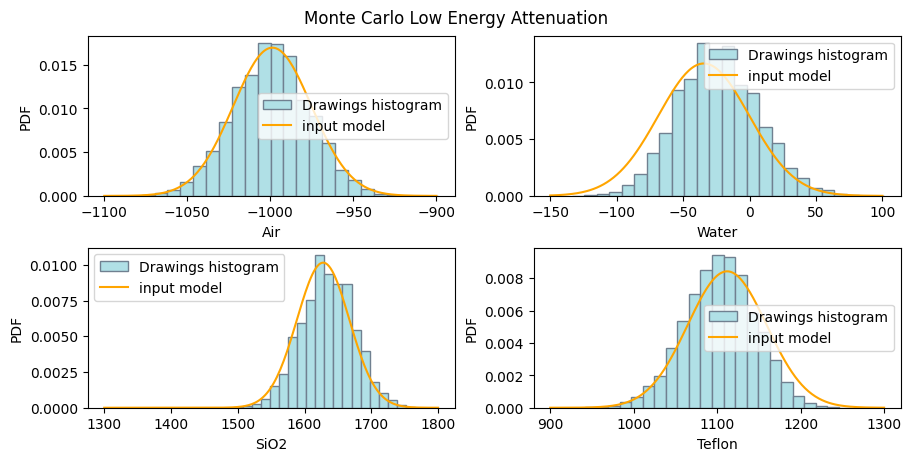

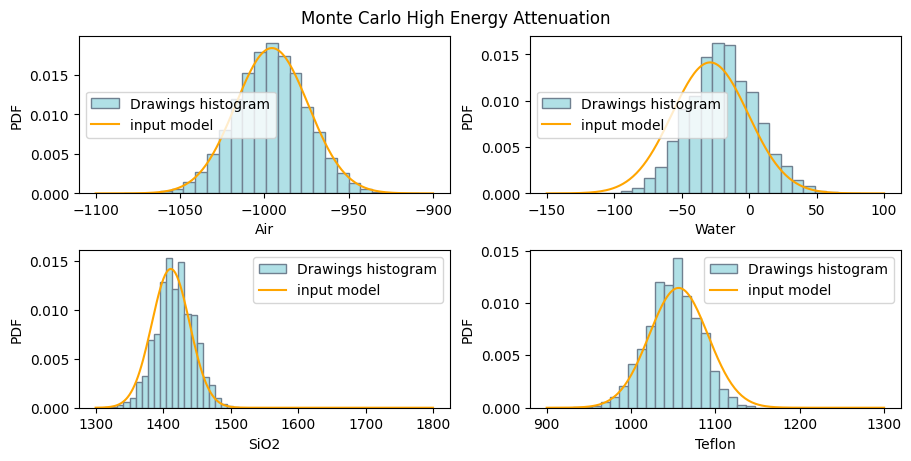

In [22]:
# Create subplots for low and high energy attenuation
fig1, ax1 = plt.subplots(2, 2, layout='constrained', figsize=(9, 4.5))
fig2, ax2 = plt.subplots(2, 2, layout='constrained', figsize=(9, 4.5))
fig1.suptitle('Monte Carlo Low Energy Attenuation')
fig2.suptitle('Monte Carlo High Energy Attenuation')

for ax, coef, mode in zip((ax1, ax2),
                          (dectgroup.lowE_inversion_coefficients,
                           dectgroup.highE_inversion_coefficients),
                          ('low', 'high')):
    for k, (i, j) in enumerate(zip((0, 0, 1, 1), (0, 1, 0, 1))):
        ax[i][j].hist(coef[f'CT_{k}'],
                      bins=25,
                      density=True,
                      facecolor='powderblue',
                      edgecolor='slategrey',
                      label='Drawings histogram')
        ax[i][j].set_xlabel(dectgroup.calibration_material[k].description)
        ax[i][j].set_ylabel('PDF')
        x_pdf, y_pdf = dectgroup.calibration_material[k].__getattribute__(f'{mode}E_pdf')
        ax[i][j].plot(x_pdf, y_pdf, color='orange', label='input model')
        ax[i][j].legend()


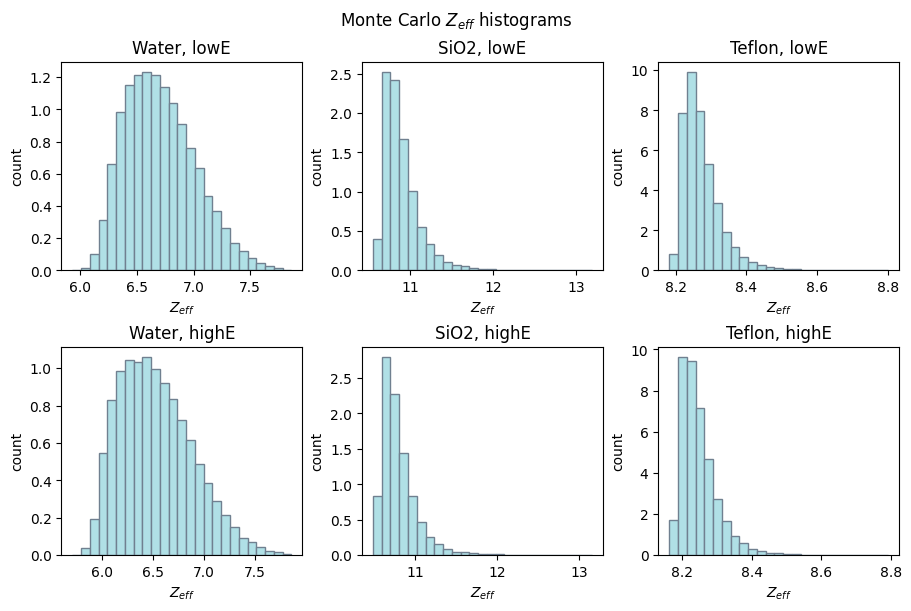

In [23]:
# Create subplots for $Z_{eff}$ histograms for low and high energy

fig1, axs = plt.subplots(2, 3, layout='constrained', figsize=(9, 6))
ax1 = axs[0][0], axs[0][1], axs[0][2]
ax2 = axs[1][0], axs[1][1], axs[1][2]
fig1.suptitle('Monte Carlo $Z_{eff}$ histograms')

for ax, coef, mode in (zip((ax1, ax2),
                           (dectgroup.lowE_inversion_coefficients,
                            dectgroup.highE_inversion_coefficients),
                            ('low', 'high'))):
    for k, xlb in enumerate(('Water', 'SiO2', 'Teflon')):
        ax[k].hist(coef[f'Z_{k+1}'],
                    bins=25,
                    density=True,
                    facecolor='powderblue',
                    edgecolor='slategrey')
        ax[k].set_title(f'{xlb}, {mode}E')
        ax[k].set_ylabel('count')
        ax[k].set_xlabel('$Z_{eff}$')


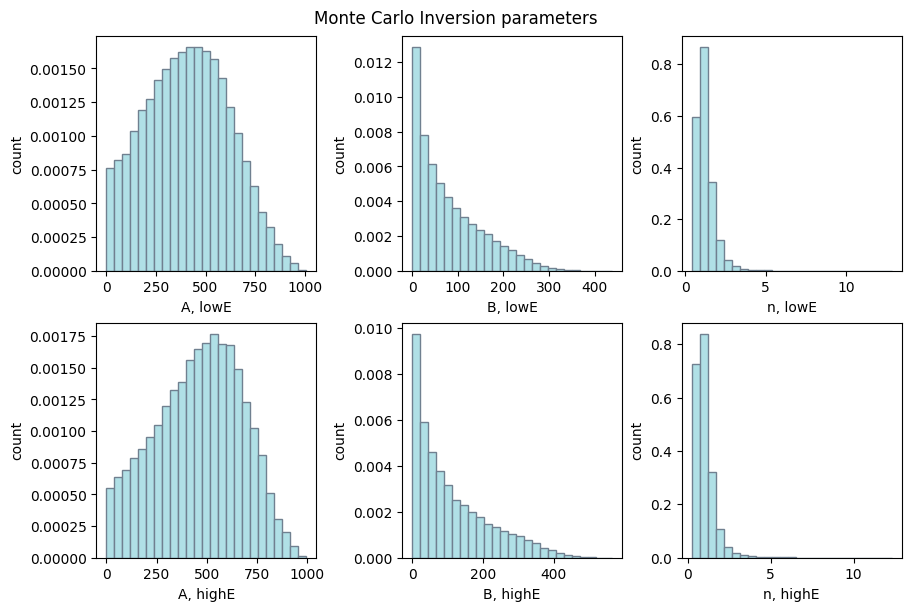

In [24]:
# Create subplots for Monte Carlo inversion parameters for low and high energy

fig1, axs = plt.subplots(2, 3, layout='constrained', figsize=(9, 6))
ax1 = axs[0][0], axs[0][1], axs[0][2]
ax2 = axs[1][0], axs[1][1], axs[1][2]
fig1.suptitle('Monte Carlo Inversion parameters')

for ax, coef, mode in (zip((ax1, ax2),
                           (dectgroup.lowE_inversion_coefficients,
                            dectgroup.highE_inversion_coefficients),
                            ('low', 'high'))):
    for k, xlb in enumerate(('A', 'B', 'n')):
        ax[k].hist(coef[f'{xlb}'],
                    bins=25,
                    density=True,
                    facecolor='powderblue',
                    edgecolor='slategrey')
        ax[k].set_xlabel(f'{xlb}, {mode}E')
        ax[k].set_ylabel('count')

Once we're happy with these results, we can move on to the next part.